In [ ]:
from google.colab import files
uploadFolder = files.upload()


Saving Satellite Image Classification.zip to Satellite Image Classification.zip


In [ ]:
import zipfile
import os

datasetZip = "Satellite Image Classification.zip"
extractFolder = "/content/Satellite Image Classification"

with zipfile.ZipFile(datasetZip, 'r') as zip_ref:
  zip_ref.extractall(extractFolder)

print("Dataset Extracted Succesfully")

Dataset Extracted Succesfully


In [ ]:
satelliteDatasetPath = "/content/Satellite Image Classification/data"

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
import os

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
satelliteImgHeight = 64
satelliteImgWidth = 64

In [ ]:
rawTrainData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                 subset = "training",
                                                                 seed = 42,
                                                                 image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                 label_mode = "categorical",
                                                                 validation_split = 0.20,
                                                                 batch_size = 64
                                                                )

AUTOTUNE = tf.data.AUTOTUNE

satelliteTrainingData = rawTrainData.cache().shuffle(1000).prefetch(AUTOTUNE)

satelliteValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  ).cache().prefetch(AUTOTUNE)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [ ]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

satelliteTrainAugmented = satelliteTrainingData.map(lambda i, j: (dataAugmentation(i), j))
# satelliteTrainAugmented

In [ ]:
satelliteNormalizationLayer = tf.keras.layers.Rescaling(1./255)

satelliteTrainNorm = satelliteTrainAugmented.map(lambda i, j: (satelliteNormalizationLayer(i), j))
satelliteValidationNorm = satelliteValidationData.map(lambda i, j: (satelliteNormalizationLayer(i), j))

In [ ]:
classNames = rawTrainData.class_names
classNames

['cloudy', 'desert', 'green_area', 'water']

In [ ]:
labels = []
for _, label in satelliteTrainNorm:
    # Convert one-hot to class index
    labels.extend(np.argmax(label.numpy(), axis = 1))

# Count Occurrences of each class
labelCounts = Counter(labels)
# print(labelCounts)

# Print class-wise count
for ind, count in labelCounts.items():
    print(f"{classNames[ind]}: {count}")

cloudy: 1233
green_area: 1182
water: 1183
desert: 907


In [ ]:
autotune = tf.data.AUTOTUNE

satelliteTrainPrefetch = satelliteTrainNorm.prefetch(buffer_size = autotune).shuffle(buffer_size = 64)
satelliteValidationPrefetch = satelliteValidationNorm.prefetch(buffer_size = autotune)

In [ ]:
classWeights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(labels),
    y = labels
)

classWeightDict = {i : classWeights[i] for i in range(len(classWeights))}
print(f"Computed Class Weights: {classWeightDict}")

Computed Class Weights: {0: 0.9134225466342255, 1: 1.2417309812568909, 2: 0.952834179357022, 3: 0.952028740490279}


In [ ]:
baseModel = ResNet50(weights = "imagenet", include_top = False, input_shape = (satelliteImgHeight, satelliteImgWidth, 3))
baseModel.trainable = False

cnnModel = keras.Sequential([
    baseModel,
    GlobalAveragePooling2D(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(len(classNames), activation = "softmax", dtype = tf.float32)
])

In [ ]:
cnnModel.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
modelHistory = cnnModel.fit(
    satelliteTrainPrefetch,
    validation_data = satelliteValidationPrefetch,
    epochs = 50,
    class_weight = classWeightDict
)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.2509 - loss: 1.4625 - val_accuracy: 0.2869 - val_loss: 1.3648
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3124 - loss: 1.3644 - val_accuracy: 0.4014 - val_loss: 1.3456
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3607 - loss: 1.3446 - val_accuracy: 0.4778 - val_loss: 1.3081
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4095 - loss: 1.3083 - val_accuracy: 0.5169 - val_loss: 1.2487
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4718 - loss: 1.2366 - val_accuracy: 0.4734 - val_loss: 1.1757
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4850 - loss: 1.1709 - val_accuracy: 0.5826 - val_loss: 1.0991
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.4959 - loss: 1.1185 - val_accuracy: 0.5924 - val_loss: 1.0368
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5302 - loss: 1.0586 - val_accuracy: 0.7069 - val_

In [ ]:
cnnModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,376,078 (92.99 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,578 (2.00 MB)

In [20]:
lossScore, accuracyScore = cnnModel.evaluate(satelliteValidationPrefetch)
print(f"Validation Accuracy: {accuracyScore:.2%}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 946ms/step - accuracy: 0.7721 - loss: 0.5436
Validation Accuracy: 77.44%


In [19]:
trueLabels = []
predictedLabels = []

for images, labels in satelliteValidationPrefetch:
    pred = cnnModel.predict(images)
    predictedLabels.extend(np.argmax(pred, axis = 1))
    trueLabels.extend(np.argmax(labels.numpy(), axis = 1))

confusionMatrix = confusion_matrix(trueLabels, predictedLabels)
print(confusionMatrix)

fig = px.imshow(confusionMatrix,
                labels = dict(x = "Predicted", y = "Actual", color = "Count"),
                x = rawTrainData.class_names,
                y = rawTrainData.class_names,
                text_auto = True,
                title = "Confusion Matrix"
               )
fig.update_layout(width = 500, height = 400)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 832ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
[[267   0   0   0]
 [  0 224   0   0]
 [  0   1 313   4]
 [ 55   4 190  68]]


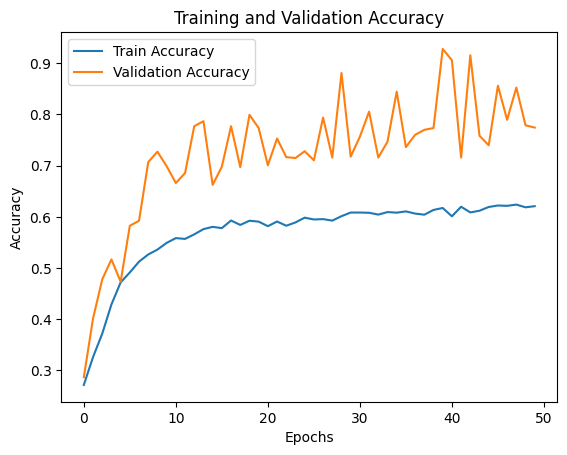

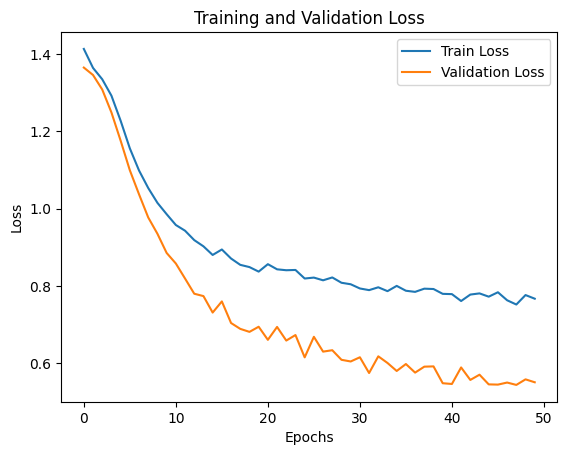

In [21]:
# Accuracy
plt.plot(modelHistory.history['accuracy'], label = "Train Accuracy")
plt.plot(modelHistory.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


# Loss
plt.plot(modelHistory.history["loss"], label = "Train Loss")
plt.plot(modelHistory.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [22]:
from PIL import Image

In [42]:
# img_path = "/content/Satellite Image Classification/data/cloudy/train_799.jpg"
# img_path = "/content/Satellite Image Classification/data/desert/desert(37).jpg"
# img_path = "/content/Satellite Image Classification/data/green_area/Forest_58.jpg"
img_path = "/content/Satellite Image Classification/data/water/SeaLake_117.jpg"

In [43]:
img = Image.open(img_path)

print(img.mode)

if img.mode == "CMYK":
    img = img.convert("RGB")

print(img.mode)

img = img.resize((128, 128))

img_array = np.array(img) / 255.0
print(img_array.shape)

img_array = np.expand_dims(img_array, axis = 0)
print(img_array.shape)

RGB
RGB
(128, 128, 3)
(1, 128, 128, 3)


In [44]:
prediction = cnnModel.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


In [45]:
predictedClass = np.argmax(prediction)
predictedClass

0

In [46]:
classLabels = rawTrainData.class_names
classLabels

['cloudy', 'desert', 'green_area', 'water']

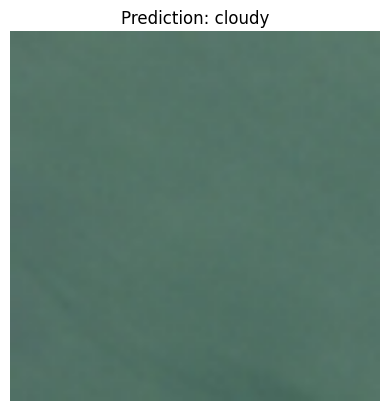

In [47]:
plt.imshow(img)
plt.title(f"Prediction: {classLabels[predictedClass]}")
plt.axis("off")
plt.show()